*Luis Antonio Ortega Andrés     
Antonio Coín Castro*

# Métodos Avanzados en Aprendizaje Automático 
# Práctica 2

In [1]:
import numpy as np

## Algoritmo de Eliminación de Variables

Este algoritmo se utiliza para hacer inferencia en redes. Supongamos que tenemos la factorización de una distribución conjunta 

$$ P(\mathbf{X}) = P(X_1, X_2, \dots, X_N) = \prod_{i=1}^N P(X_i|Par(X_i))$$ 

y una evidenica $ \mathbf{Z}=\mathbf{z} $, donde $\mathbf{Z} \subset \mathbf{X}$ es un subconjunto de las variables del problema y $\mathbf{z}$ son sus valores observados. El objetivo es obtener la distribución de parte de las variables del problema, $\mathbf{W} \subset \mathbf{X}$, dada la evidencia $\mathbf{Z}=\mathbf{z}$. Es decir, queremos obtener $P(\mathbf{W}|\mathbf{Z}=\mathbf{z})$:

$$ P(\mathbf{W}|\mathbf{Z}=\mathbf{z}) = \sum_{X \setminus (W\cup Z)} \frac{P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z})}{P(\mathbf{Z}=\mathbf{z})} \propto \sum_{X \setminus (W\cup Z)} P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z}).$$

Para ello debemos:

* Reducir los factores que incluyan $\mathbf{Z}$.
* Eliminar el resto de variables no incluidas $\mathbf{W}$.


Algoritmo de eliminación de variables esquemático para un conjunto de factores $\mathbf{\Phi}=\{\Phi_1,\dots,\Phi_N\}$:
1.  Reducir todos los factores que contengan alguna variable de $\mathbf{Z}$ en su dominio, usando la evidencia dada $\mathbf{Z}=\mathbf{z}$.
2.  Para cada variable X en $\mathbf{X} \setminus (\mathbf{W} \cup \mathbf{Z})$, eliminar la variable X mediante marginalización:
    1. Hacer el producto de todos los factores que tienen X en su dominio: $\psi = \prod_{i \mid X\in Dom(\Phi_i) }\Phi_i$. 
    2. Marginalizar X del factor producto obtenido en A: $\tau = \sum_X \psi$.
    3. Actualizar la lista de factores quitando los factores que incluyen X y añadiendo el factor marginalizado $\tau$: $\mathbf{\Phi} = (\mathbf{\Phi} \setminus {\psi}) \cup \tau$.
3. Multiplicar factores restantes.
4. Renormalizar para obtener una distribución.

Definimos una clase para representar una red bayesiana a partir de la factorización de la distribución conjunta. Nos ayudamos de una serie de funciones auxiliares para normalizar, marginalizar y reducir factores, e implementamos un método para aplicar el algoritmo de eliminación de variables.

In [3]:
class BayesianNetwork:
    """
    Represents a Bayesian Network via its joint distribution decomposition.
    """
    
    def __init__(self, factor_list):
        """ Construct a network from its factorization. Every factor must have the same
            number of dimensions, which coincides with the total number of variables."""
        
        self.factor_list = factor_list
        self.variables = np.arange(len(self.factor_list))

    def _normalize(self, distribution):
        """ Normalize a distribution so that all values add up to 1. """

        return distribution / np.sum(distribution)

    def _marginal(self, distribution, variables):
        """ Marginalize a distribution for the given list of (indices of) variables. """

        return np.sum(distribution, axis = tuple(variables), keepdims = True)

    def _reduce(self, distribution, variables, asignments, normalize_output = True):
        """ This function receives a distribution, 
            a list of indices to variables and 
            a list of assignments to those variables.
            
            It performs reduction on the specified variables with the given assignments. """

        reduced = distribution.copy()
        for variable, asignment in zip(variables, asignments):
            reduced = np.swapaxes(reduced, 0, variable)[[asignment]]
            reduced = np.swapaxes(reduced, 0, variable)

        return self._normalize(reduced) if normalize_output else reduced
    
    def _factor_has_var(self, factor, variable):
        """ Return whether a given factor has a specific variable on its domain. """

        return factor.shape[variable] > 1

    def _multi_prod(self, arrays):
        """ Perform the element-wise product of multiple arrays. """
        
        assert(len(arrays) > 0)

        res = arrays[0]
        for arr in arrays[1:]:
            res = res * arr

        return res

    def VE(self, W, Zs = [], zs = [], order = []):
        """ Implement the variable elimination algorithm.

            Input:
                * W:       list of desired variables in the output factor.
                * Zs:      list with the observed variables.
                * zs:      list with the values of the observed variables.
                * order:   order in which the variables not in (W U Zs) are processed. 
                           If empty, an ascending order is assumed. If not empty, the indices
                           must be relative to the ones in self.factor_list.
            
            Ouput:
                * Factor representing the joint distribution P(W|Zs=zs).
                * The size of the biggest factor processed.
        """
        
        factors = self.factor_list.copy()
        variables_factors = np.arange(len(factors))

        # -- STEP 1: reduce factors that contain any variable in Zs --
        for Z, z in zip(Zs, zs):
            for i, factor in enumerate(factors):
                if self._factor_has_var(factor, Z):
                    factors[i] = self._reduce(factor, [Z], [z], False)

        # -- STEP 2: eliminate variables via marginalization --
        variables_rest = np.setdiff1d(variables_factors, np.union1d(W, Zs))
        
        # Take the desired ordering into account
        if len(order) > 0:
            assert((np.unique(order) == np.unique(variables_rest)).all() 
                      and len(order) == len(variables_rest))
            variables_rest = order
            
        # Process each variable in order
        max_size = 0
        for X in variables_rest:
            # Recover the indices of factors that have X on their domain
            factors_X_idx = [i for i in variables_factors if self._factor_has_var(factors[i], X)]
            
            # Multiply those factors together
            psi = self._multi_prod([factors[i] for i in factors_X_idx])
            
            # Marginalize the product with respect to X
            tau = self._marginal(psi, [X])
            
            # Update the factor list
            factors = [factors[i] for i in np.setdiff1d(variables_factors, factors_X_idx)] + [tau]
            variables_factors = np.arange(len(factors))
            
            # Compute size of the processed factor
            max_size = max(max_size, np.prod(psi.shape))

        # -- STEPS 3 and 4: multiply the remaining factors and normalize --
        res = self._normalize(self._multi_prod([*factors]))
        
        return res, max_size

Definimos una distribución para probar el algoritmo, basándonos en el siguiente grafo:

![estu](img/estu2.png)

Las variables representadas son:

* **Nota examen (G)**: g0 (sobresaliente), g1 (notable), g2 (aprobado).
* **Dificultad examen (D)**: d0 (fácil) y d1 (difícil).
* **Inteligencia (I)**: i0 (normal), i1 (alta).
* **Nota Selectividad (S)**: s0 (baja), s1 (alta).
* **Carta de recomendación (L)**: l0 (regular), l1 (buena).

La distribución conjunta es entonces:

$$P(I,D, G,L,S) = P(I)P(D)P(G|I,D)P(L|G)P(S|I).$$

In [4]:
# Dimensión -> 0  1  2  3  4
# Variable  -> I  D  G  L  S

PI = np.array([0.7, 0.3]).reshape((2, 1, 1, 1, 1))
PD = np.array([0.6, 0.4]).reshape((1, 2, 1, 1, 1))
PG_ID = np.array([0.3, 0.4, 0.3, 0.05, 0.25, 0.7, 0.9, 0.08, 0.02, 0.5, 0.3, 0.2]).reshape((2, 2, 3, 1, 1))
PL_G = np.array([0.1, 0.9, 0.4, 0.6, 0.99, 0.01]).reshape((1, 1, 3, 2, 1))
PS_I = np.array([0.95, 0.05, 0.2, 0.8]).reshape((2, 1, 1, 1, 2))

# Distribución conjunta
PIDGLS = PI * PD * PG_ID * PL_G* PS_I

# Red bayesiana
network = BayesianNetwork([PI, PD, PG_ID, PL_G, PS_I])

Establecemos una serie de casos de prueba.

In [5]:
# ¿Cuál es la distribución P(I)?
factor, max_size = network.VE([0])
assert(np.allclose(np.array([[[[[0.7]]]], [[[[0.3]]]]]), factor))
assert(max_size == 12)

# Si sabemos que la nota del examen es aprobado, ¿cuál es la distribución de la inteligencia? 
# P(I|G=g2)
factor, max_size = network.VE([0], [2], [2])
assert(np.allclose(np.array([[[[[0.92105263]]]], [[[[0.07894737]]]]]), factor))
assert(max_size == 4)

# Y si además el examen es difícil?
# P(I|G=g2,D=d1)
factor, max_size = network.VE([0], [1,2], [1,2])
assert(np.allclose(np.array([[[[[0.89090909]]]], [[[[0.10909091]]]]]), factor))
assert(max_size == 4)

print("Todos los casos de prueba son correctos.")

Todos los casos de prueba son correctos.


In [6]:
# Calcula la distribución P(D)
factor, max_size = network.VE([1])
assert(np.allclose(np.array([[[[[0.6]]], [[[0.4]]]]]), factor))
assert(max_size == 24)

# Prob examen si nota es aprobado: P(D|G=g2)
factor, max_size = network.VE([1], [2], [2])
assert(np.allclose(np.array([[[[[0.37070938]]], [[[0.62929062]]]]]), factor))
assert(max_size == 8)

# Probabilidad de examen difícil D=d1 dado que G=g2 y S=s1
factor, max_size = network.VE([1], [2,4], [2,1])
assert(np.allclose(np.array([[[[[0.24044002]]], [[[0.75955998]]]]]), factor))
assert(max_size == 4)

print("Todos los casos de prueba son correctos.")

Todos los casos de prueba son correctos.


Finalmente estudiamos cómo influyen unas variables sobre otras, dependiendo de la evidencia que tengamos. En concreto, nos preguntamos si la nota de selectividad (S) influye en la dificultad del examen (D), dependiendo de si conocemos o no su nota (G).

In [7]:
# P(D)
pd, _ = network.VE([1])
print("Distribución de D:\n", pd)

# P(D|S=1), no conocemos G
pd_s1, _ = network.VE([1], [4], [1])
print("\nDistribución de D|S=1:\n", pd_s1)
if np.allclose(pd_s1, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

# P(D|G=2)
pd_g2, _ = network.VE([1], [2], [2])
print("\nDistribución de D|G=2:\n", pd_g2)
if np.allclose(pd_g2, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

# P(D|G=2,S=1), conocemos G
pd_g2s1, _ = network.VE([1], [2, 4], [2, 1])
print("\nDistribución de D|G=2,S=1:\n", pd_g2s1)
if np.allclose(pd_g2s1, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

Distribución de D:
 [[[[[0.6]]]


  [[[0.4]]]]]

Distribución de D|S=1:
 [[[[[0.6]]]


  [[[0.4]]]]]
--> No cambia

Distribución de D|G=2:
 [[[[[0.37070938]]]


  [[[0.62929062]]]]]
--> Cambia

Distribución de D|G=2,S=1:
 [[[[[0.24044002]]]


  [[[0.75955998]]]]]
--> Cambia


## Implementación de Gradient Boosting

$\DeclareMathOperator*{\argmin}{arg\,min}$
Entrada: training set $\{(x_n, y_n\}_{n=1,\dots,N}$, una función de pérdida diferenciable $L(y,F(x))$ y un número de iteraciones $M$.

1. Inicializa el modelo con un clasificador constante
$$
F_0 (x) = \argmin_{\gamma} \sum_{n=1}^N L(y_n, \gamma).
$$
2. Para $m = 1,\dots,M$:
    1. Computa los "pseudo-residuos":
    $$
        r_{n,m} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} \quad n = 1,\dots,N
    $$
    2. Ajusta un modelo base $h_m(x)$ a los pseudo-residuos, es decir, entrenalo sobre el conjunto $\{x_n, r_{n,m}\}_{n=1,\dots,N}$
    3. Computa el multiplicador $\gamma_m$ que minimiza el error en entrenamiento (paso de Newton-Raphson).
    $$
    \gamma_m = \argmin_\gamma \sum_{n=1}^N L(y_n, F_{m-1}(x_n) + \gamma h_m(x_n)).
    $$
    4. Actualiza el modelo
    $$
    F_m(x) F_{m-1}(x) + \gamma_m h_m(x).
    $$
3. Devuelve $F_M(x)$.

### Error cuadrático.

Creamos la clase que modela los elementos del algoritmo correspondientes al uso del error cuadrático
$$
L(y, F(x)) = (y - F(x))^2.
$$
Entre estos elementos se encuentra: el cálculo del estimador inicial $F_0$, el cálculo de residuos, la minimización del paso de Newton-Raphson y el cálculo del propio error.

1. **Estimador inicial**. En este caso, el valor del estimador constante inicial coincide con la media:
$$
\argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N (y_n - \gamma)^2
$$

$$
\frac{\partial \sum_{n=1}^N L(y_n, \gamma)}{\partial \gamma} = \sum_{n=1}^N(y_n - \gamma) = 0 \implies \gamma = \frac{1}{N}\sum_{n=1}^N y_n.
$$
2. **Pseudo-residuos**. 
$$
r_{n,m} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial (y_n - F(x_n)^2}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = 2(y_n - F_{m-1}(x_n))
$$

3. **Multiplicador**. Al no poder computar el valor que anula la siguiente derivada, le aplicamos un paso del método de Newton-Rapson:
$$
f(\rho) = \frac{\partial}{\partial \rho} \sum_{n=1}^N (y_n - F_{m-1}(x_n) - \rho h_m(x_n))^2
$$
$$
f(\rho) = \sum_{n=1}^N -2h_m(x_n)(y_n - F_{m-1}(x_n) - \rho h_m(x_n))
$$

$$
f'(\rho) = \sum_{n=1}^N 2h_m(x_n)^2
$$

$$
\rho^{new} = -\frac{f(\rho = 0)}{f'(\rho = 0)} = \frac{\sum_{n=1}^N 2h_m(x_n)(y_n - F_{m-1}(x_n))}{\sum_{n=1}^N 2h_m(x_n)^2}
$$
Donde, utilizando que 
$$
h_m(x_n) \approx r_{n,m} = 2(y_n- F_{m-1}(x_n))
$$
$$
\rho^{new} = \frac{\sum_{n=1}^N 4(y_n- F_{m-1}(x_n))(y_n - F_{m-1}(x_n))}{\sum_{n=1}^N 4(y_n- F_{m-1}(x_n))^2} = 1
$$

In [127]:
class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión"""
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        """ 
            Calcula el primer sumando del estimador final F0. Al utilizar la función de perdida cuadrática, 
            este valor coincide con la media de los valores.
        """
        return np.median(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        """
            Calcula el valor de los pseudo-residuos. 
        """
        return np.sign(y - F)

    def paso_newton(_, y, residuos, ht):
        """ Recibe el valor a predecir (y), los pseudo-residuos (residuos) 
            sobre los que se entrena el regresor ht y la salida del nuevo 
            regresor creado (ht) """
        """
            Calcula el multiplicador a partir de y, los residuos y el nuevo estimador de estos ultimos
        """
        return 1
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return (y-F)**2

### Error logístico

Creamos la clase que modela los elementos del algoritmo correspondientes al uso del error cuadrático
$$
L(y, F(x)) = \log(1 + \exp(-2yF)), \quad y \in \{-1,1\}.
$$
Entre estos elementos se encuentra: el cálculo del estimador inicial $F_0$, el cálculo de residuos, la minimización del paso de Newton-Raphson y el cálculo del propio error.

1. **Estimador inicial**. En este caso, el valor del estimador constante inicial coincide con la media:
$$
\argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N \log(1 + \exp(-2y_n \gamma))
$$

$$
\frac{\partial \sum_{n=1}^N L(y_n, \gamma)}{\partial \gamma} = \frac{-2y_n \exp(-2y\gamma)}{1 + \exp(-2y_n \gamma))} = 0 \implies \gamma = \frac{1}{N}\sum_{n=1}^N y_n.
$$
2. **Pseudo-residuos**. 
$$
r_{n,m} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial (y_n - F(x_n)^2}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = 2(y_n - F_{m-1}(x_n))
$$

3. **Multiplicador**. Al no poder computar el valor que anula la siguiente derivada, le aplicamos un paso del método de Newton-Rapson:
$$
f(\rho) = \frac{\partial}{\partial \rho} \sum_{n=1}^N (y_n - F_{m-1}(x_n) - \rho h_m(x_n))^2
$$
$$
f(\rho) = \sum_{n=1}^N -2h_m(x_n)(y_n - F_{m-1}(x_n) - \rho h_m(x_n))
$$


In [127]:
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return 0.5*np.log((1+np.mean(y))/(1-np.mean(y)))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return 2*y/(1 + np.exp(2*y*F))

    def paso_newton(_, y, residuos, ht):
        """ Recibe el valor a predecir (y), los pseudo-residuos (residuos) 
            sobre los que se entrena el regresor ht y la salida del nuevo 
            regresor creado (ht) """
        return np.sum( residuos/(np.abs(residuos)*(2 - np.abs(residuos))) )

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))

In [127]:
from sklearn.tree import DecisionTreeRegressor

class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), reg = True, eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self._multipliers = []
        self.depth        = depth
        self.eta          = eta
        self.loss         = loss
        self.reg          = reg
        
    def _transform_output(self, y):
        y =  (1/(1 + np.exp(-2*y)) > 0.5).astype(int)
        y[ y == 0] = -1
        return y
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        self.F0 = self.loss.F0(X, y)
        F = self.F0*np.ones(len(y))
        print("F:", F)

    
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth)
            """
              Rellenar esta parte para implementar GB        
            """
            r = self.loss.residuos(y, F)
            tree.fit(X,r)
            pred = tree.predict(X)
            mult = self.loss.paso_newton(y, r, pred)
            self._multipliers.append(mult)
            self._estimators.append(tree)
            
            F += mult*pred
            print("Residuos: ", r)
            print("F:", F)
            print("Mult:", mult)
        
        pass
        
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """
        salida = self.F0
        for i in range(self.n_estimators):
            salida += self._multipliers[i]*self._estimators[i].predict(X)
                
        if self.reg == True:
            return salida
        
        return self._transform_output(salida)

In [128]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    print(z)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [129]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [130]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

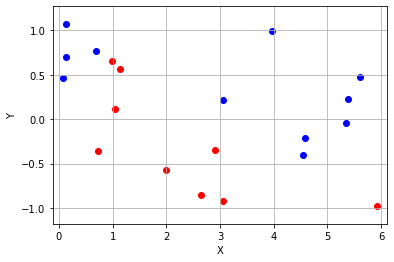

In [131]:
# Problem data:
np.random.seed(11)
import matplotlib.pyplot as plt
n = 20
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)

In [132]:
ytrain

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

In [133]:
gb = GBCasero(loss=LogLoss(), reg = False)

ytr = np.ones_like(ytrain)
ytr[ytrain==0] = -1
gb.fit(Xtrain, ytr)

z = gb.predict(ytr)
print(z)

plotModel(x1,x2,ytrain,gb)

#TODO: medir tiempos, comparar con otro conjunto "real"?

F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Residuos:  [-1.1  0.9 -1.1  0.9 -1.1 -1.1  0.9  0.9 -1.1  0.9  0.9  0.9  0.9  0.9
 -1.1  0.9  0.9 -1.1 -1.1 -1.1]
F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Mult: -8.881784197001252e-16
Residuos:  [-1.1  0.9 -1.1  0.9 -1.1 -1.1  0.9  0.9 -1.1  0.9  0.9  0.9  0.9  0.9
 -1.1  0.9  0.9 -1.1 -1.1 -1.1]
F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Mult: -2.220446049250313e-15
Residuos:  [-1.1  0.9 -1.1  0.

<ipython-input-127-80d4a857bf41>:58: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum( residuos/(np.abs(residuos)*(2 - np.abs(residuos))) )
/usr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').